# Finite strain
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/basic/planar/finite_strain.ipynb)

We compare planar strain and planar stress models employing Hencky strains.

In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np
from torchfem.examples import get_example_file
from torchfem.io import import_mesh
from torchfem.materials import (
    IsotropicHenckyPlaneStrain,
    IsotropicHenckyPlaneStress,
)

# Set default data type to double precision
torch.set_default_dtype(torch.float64)

# Dimensions (thickness of plate t and edge length L)
t = 0.01
L = 0.2

# Incremental loading
increments = torch.linspace(0.0, 1.0, 21)
DU = 0.05

## Plane strain

In [2]:
# Material model (plane stress)
material = IsotropicHenckyPlaneStrain(E=1000.0, nu=0.3)

# Import mesh
plate = import_mesh(get_example_file("plate_hole.vtk"), material)
plate.thickness[:] = t

# Fixed boundary at left end
left = plate.nodes[:, 0] < 1e-6
plate.constraints[left] = True

# Load at right end
right = plate.nodes[:, 0] > L - 1e-6
plate.constraints[right] = True
plate.displacements[right, 0] = DU

# Solve
u, f, σ, F, _ = plate.solve(
    increments=increments[:19], return_intermediate=True, nlgeom=True
)

# Post-process
C = F.transpose(-1, -2) @ F
ev, Q = torch.linalg.eigh(C)
LE = 0.5 * Q @ torch.diag_embed(torch.log(ev)) @ Q.transpose(-1, -2)

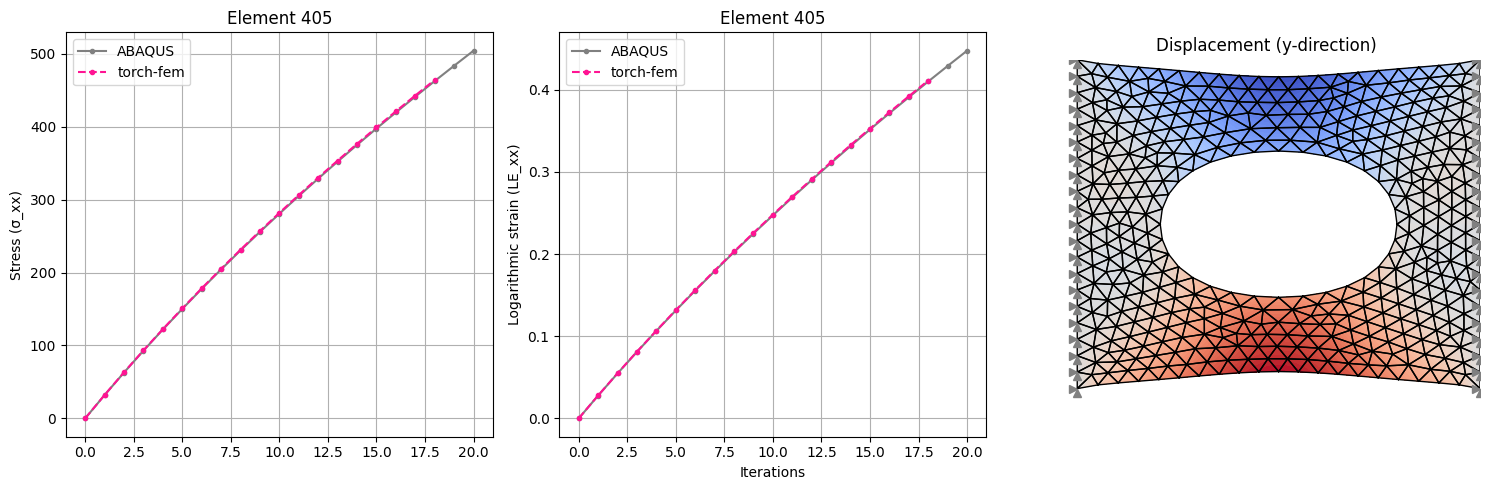

In [3]:
ref_data = np.array(
    [
        [0.00000, 000.000],
        [0.02777, 031.969],
        [0.05472, 062.871],
        [0.08094, 092.823],
        [0.10646, 121.874],
        [0.13131, 150.096],
        [0.15556, 177.549],
        [0.17923, 204.287],
        [0.20236, 230.359],
        [0.22498, 255.811],
        [0.24713, 280.683],
        [0.26883, 305.013],
        [0.29010, 328.833],
        [0.31097, 352.175],
        [0.33147, 375.067],
        [0.35160, 397.536],
        [0.37139, 419.604],
        [0.39086, 441.295],
        [0.41003, 462.629],
        [0.42890, 483.624],
        [0.44750, 504.298],
    ]
)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(ref_data[:, 1], ".-", color="gray", label="ABAQUS")
ax[0].plot(σ[:, 405, 0, 0], ".--", color="deeppink", label="torch-fem")
ax[0].grid()
ax[0].title.set_text("Element 405")
ax[0].set_ylabel("Stress (σ_xx)")
ax[0].legend()
ax[1].plot(ref_data[:, 0], ".-", color="gray", label="ABAQUS")
ax[1].plot(LE[:, 405, 0, 0], ".--", color="deeppink", label="torch-fem")
ax[1].grid()
ax[1].title.set_text("Element 405")
ax[1].set_ylabel("Logarithmic strain (LE_xx)")
ax[1].legend()
ax[1].set_xlabel("Iterations")

plate.plot(
    u=u[-1],
    node_property=u[-1, :, 1],
    cmap="coolwarm",
    title="Displacement (y-direction)",
    ax=ax[2],
)
plt.tight_layout()
plt.show()

## Plane stress

In [4]:
# Material model (plane stress)
material = IsotropicHenckyPlaneStress(E=1000.0, nu=0.3)

# Import mesh
plate = import_mesh(get_example_file("plate_hole.vtk"), material)
plate.thickness[:] = t

# Fixed boundary at left end
left = plate.nodes[:, 0] < 1e-6
plate.constraints[left] = True

# Load at right end
right = plate.nodes[:, 0] > L - 1e-6
plate.constraints[right] = True
plate.displacements[right, 0] = DU

In [5]:
# Solve
u, f, σ, F, state = plate.solve(
    increments=increments[:19], return_intermediate=True, nlgeom=True
)

# Post-process
C = F.transpose(-1, -2) @ F
ev, Q = torch.linalg.eigh(C)
LE = 0.5 * Q @ torch.diag_embed(torch.log(ev)) @ Q.transpose(-1, -2)

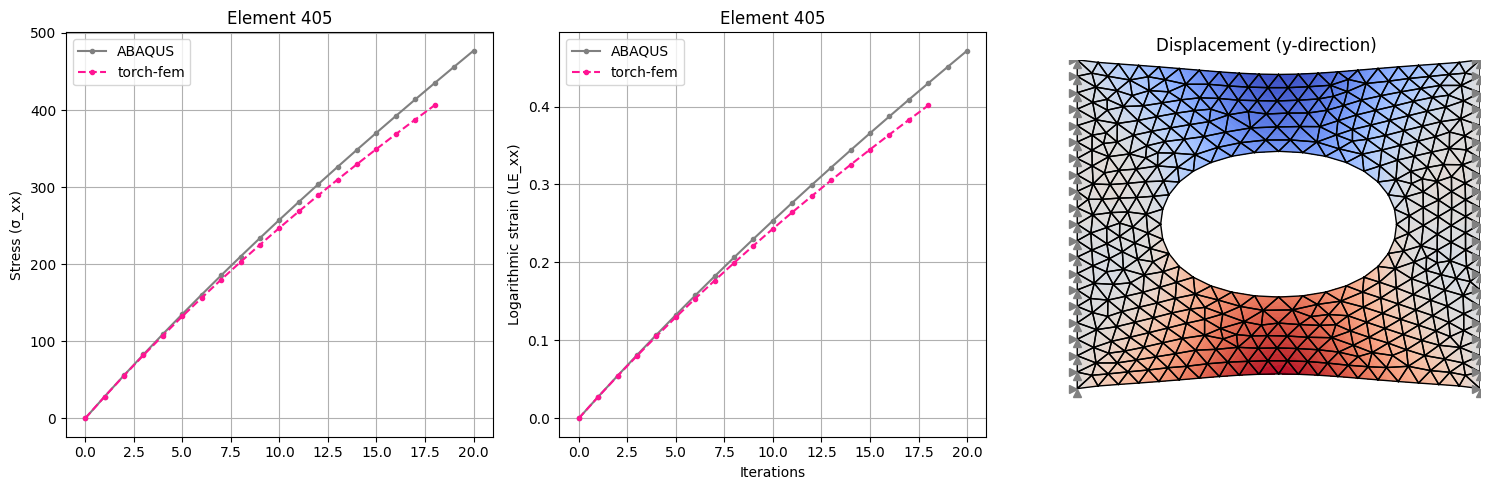

In [6]:
ref_data = np.array(
    [
        [0.00000, 0.00000],
        [0.02762, 28.2587],
        [0.05466, 55.8530],
        [0.08117, 82.8578],
        [0.10715, 109.285],
        [0.13265, 135.172],
        [0.15767, 160.548],
        [0.18226, 185.445],
        [0.20642, 209.892],
        [0.23020, 233.916],
        [0.25360, 257.544],
        [0.27665, 280.800],
        [0.29937, 303.709],
        [0.32179, 326.293],
        [0.34391, 348.573],
        [0.36577, 370.571],
        [0.38737, 392.307],
        [0.40874, 413.800],
        [0.42990, 435.068],
        [0.45085, 456.132],
        [0.47162, 477.007],
    ]
)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(ref_data[:, 1], ".-", color="gray", label="ABAQUS")
ax[0].plot(σ[:, 405, 0, 0], ".--", color="deeppink", label="torch-fem")
ax[0].grid()
ax[0].title.set_text("Element 405")
ax[0].set_ylabel("Stress (σ_xx)")
ax[0].legend()
ax[1].plot(ref_data[:, 0], ".-", color="gray", label="ABAQUS")
ax[1].plot(LE[:, 405, 0, 0], ".--", color="deeppink", label="torch-fem")
ax[1].grid()
ax[1].title.set_text("Element 405")
ax[1].set_ylabel("Logarithmic strain (LE_xx)")
ax[1].legend()
ax[1].set_xlabel("Iterations")

plate.plot(
    u=u[-1],
    node_property=u[-1, :, 1],
    cmap="coolwarm",
    title="Displacement (y-direction)",
    ax=ax[2],
)

# plate.plot(
#     u=u[-1],
#     element_property=state[-1, :, 0] + 1,
#     cmap="viridis",
#     title="Out-of-plane stretch (λ_z)",
#     ax=ax[2],
#     colorbar=True,
# )
plt.tight_layout()
plt.show()